In [124]:
"""This module prepares the data, splits into train/test, and performs undersampling to balance the data set. 
Then it trains and compares these machine learning models:
- Logistic Regression
- Ridge Classifier
- Random Forest Classifier
- K-Neighbours Classifier
-"""

import sqlite3

import pandas as pd

try:
    database_path = "data/data.db"
    conn = sqlite3.connect(database_path)
    query = open('data/fetch_all.sql', 'r').read()
    df_raw = pd.read_sql_query(query, conn)
except (sqlite3.Error, FileNotFoundError) as e:
    print(f"An error occurred: {e}")
finally:
    if 'conn' in locals():
        conn.close()

# NOTE: Filtering only rows with 'yes' or 'no' in the 'y' column for training
df_full = df_raw.copy()
df_raw.set_index('client_id', inplace=True)

df = df_raw[df_raw['y'].isin(['no', 'yes'])]

# Isolate the unseen data NOTE: In unseen data, excluding clients who had outcome TODO: Check if this is correct
# df_pool = df_raw[df_raw['y'].isin(['yes', 'unknown'])]
# df_pool.head()

# NOTE: Dropping columns that are not useful for training
# NOTE: Dropping month as it's heavily skewed towards May. Not useful for further analysis.
# NOTE: Dropping previous and poutcome as they are not useful for training
cols_to_drop = ['account_id', 'campaign_id', 'outcome_id', 'previous', 'poutcome', 'month']
df = df.drop(columns=cols_to_drop)
df_pool = df_raw.drop(columns=cols_to_drop, inplace=True)


In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


def preprocess_data(df):
    # NOTE: Binning day of the week into Early, Mid, and Late
    bins = [0, 9, 19, 31]
    labels = ['early', 'mid', 'late']
    df['day_bin'] = pd.cut(df['day'], bins=bins, labels=labels, right=True)

    # NOTE: Binning age into common bins
    age_bins = [0, 25, 36, 55, 65, 100]
    age_labels = ['<25', '25-35', '36-55', '55-65', '65+']
    df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

    # Identify numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = ['job', 'marital', 'education', 'in_default', 'housing', 'loan', 'contact', 'day_bin',
                           'age_bin', 'y']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(df[categorical_columns])

    # Create a DataFrame with the encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the numerical columns
    scaled_numeric_features = scaler.fit_transform(df[numerical_columns])

    # Create a DataFrame with the scaled numerical features
    scaled_numeric_df = pd.DataFrame(scaled_numeric_features, columns=numerical_columns)

    # Concatenate the scaled numerical features and the encoded categorical features
    df_enc = pd.concat([scaled_numeric_df, encoded_df], axis=1)

    return df_enc


df_enc = preprocess_data(df)
df_enc.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'in_default_yes',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'day_bin_late', 'day_bin_mid', 'age_bin_36-55', 'age_bin_55-65',
       'age_bin_65+', 'age_bin_<25', 'y_yes'],
      dtype='object')

In [126]:
from imblearn.over_sampling import SMOTE
# NOTE: Data is imbalanced, so for training we are using synthetic data generated by SMOTE.
X = df_enc.drop(columns=['y_yes'])
y = df_enc['y_yes']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [127]:
from sklearn.model_selection import train_test_split

# NOTE: Spliting the data into train and test sets wtih an 80:20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6400, 33)
X_test shape: (1600, 33)
y_train shape: (6400,)
y_test shape: (1600,)


Model: Logistic Regression
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Cross-Validation Score: 0.8112499999999999
Test Accuracy: 0.8
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       803
         1.0       0.80      0.80      0.80       797

    accuracy                           0.80      1600
   macro avg       0.80      0.80      0.80      1600
weighted avg       0.80      0.80      0.80      1600



Model: Ridge Classifier
Best Parameters: N/A (RidgeClassifierCV performs internal CV)
Cross-Validation Score: 0.80421875
Test Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       803
         1.0       0.79      0.79      0.79       797

    accuracy                           0.79      1600
   macro avg       0.79      0.79      0.79      1600
weighted avg       0.79      0.79      0.79      1600



Model: Random F

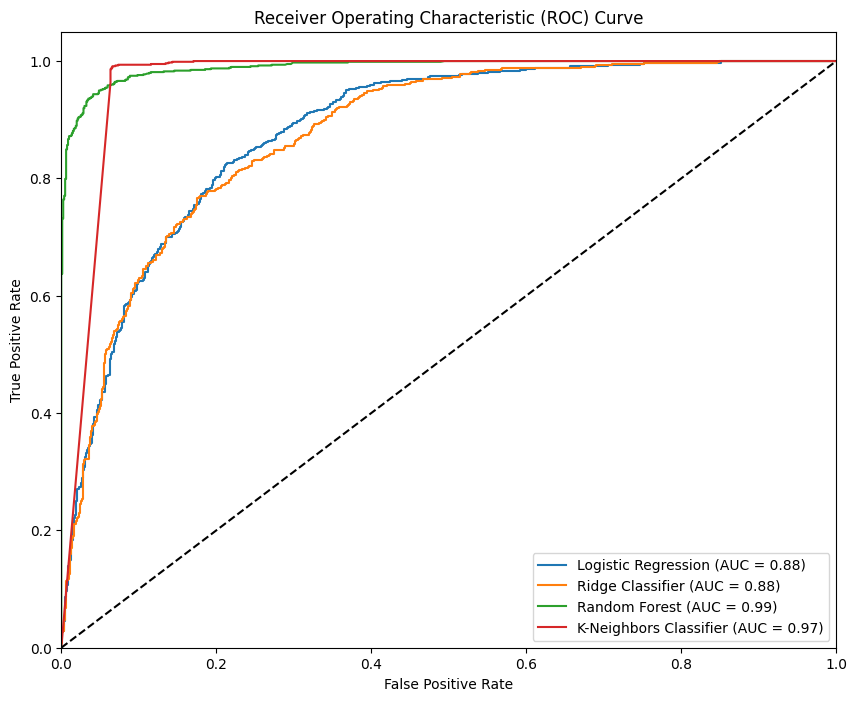

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Define the models and their hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear']
        }
    },
    'Ridge Classifier': {
        'model': RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'K-Neighbors Classifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and hyperparameter tuning
results = []
roc_data = {}
for model_name, model_info in models.items():
    if model_name == 'Ridge Classifier':
        clf = model_info['model']
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.decision_function(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        roc_data[model_name] = (y_test, y_pred_proba)
        results.append({
            'Model': model_name,
            'Best Parameters': 'N/A (RidgeClassifierCV performs internal CV)',
            'Cross-Validation Score': clf.score(X_train, y_train),
            'Test Accuracy': accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        })
    else:
        clf = GridSearchCV(model_info['model'], model_info['params'], cv=kf, scoring='accuracy')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        roc_data[model_name] = (y_test, y_pred_proba)
        results.append({
            'Model': model_name,
            'Best Parameters': clf.best_params_,
            'Cross-Validation Score': clf.best_score_,
            'Test Accuracy': accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        })

# Display the results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Cross-Validation Score: {result['Cross-Validation Score']}")
    print(f"Test Accuracy: {result['Test Accuracy']}")
    print(f"Classification Report:\n{result['Classification Report']}")
    print("\n" + "=" * 80 + "\n")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, (y_test, y_pred_proba) in roc_data.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42)
best_rf_model.fit(X_train, y_train)

Stored 'best_rf_model' (RandomForestClassifier)


/home/vincemcc/repos/vijl/venv/lib/python3.12/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/best_rf_model requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [ ]:
# NOTE: Clients with insufficient balance are unlikely to invest in term deposits. We will filter out these clients.
# Filter rows where 10.82% of the balance is greater than or equal to 200. Based on two assumptions:
# The mean proportion of the balance that people invest in term deposits is 10.82%
# The minimum threshold for a term deposit with the high street banks is EUR 200

df_pool = df_raw.loc[(df_raw['balance'] > 122) & (df_raw['balance'] <= 3750)]
# NOTE: why these numbers? We noticed that very low and very high balance clients had a low success rate in the previous campaign. 
# So we aimed to target the mid range. We ran 600 simulations, and these were the optimal figures.

cols_to_drop = ['account_id', 'campaign_id', 'outcome_id', 'previous', 'poutcome', 'month', 'y_unknown']
data_pre_proc = preprocess_data(df_pool.copy())
data_cleaned = data_pre_proc.drop(columns=['y_yes', 'y_unknown'])

# data_cleaned['Probability'] = best_rf_model.predict(data_cleaned)
data_cleaned['Probability'] = best_rf_model.predict_proba(data_cleaned)[:, 1]


In [ ]:
# Print the first few probabilities
print(data_cleaned['Probability'] < 0.5)
# print(data_cleaned['Probability'].value_counts())

In [132]:
conversion = (data_cleaned['Probability'].value_counts())
print(conversion)
conversion_rate = conversion.iloc[1] / conversion.iloc[0]
print(f"Conversion rate: {conversion_rate}")
print(3490/5000)

Probability
0.0    24210
1.0     3490
Name: count, dtype: int64
Conversion rate: 0.14415530772408097
0.698


In [133]:
# Select the top 5,000 eligible clients
selected_clients = data_cleaned.sort_values(by='Probability', ascending=False).head(5000)
selected_client_ids = df_full.loc[selected_clients.index, ['client_id']]

print(selected_clients[['balance', 'Probability']])

selected_client_ids.to_csv("second_phase_target.csv", index=False, header=['target'])
selected_clients.index.name = 'target'
selected_clients.to_csv("second_phase_target_complete.csv", index=True)

assert df_full.loc[1893]['client_id'] == 1790568

        balance  Probability
20991 -0.364277          1.0
15778  0.055735          1.0
24760  0.542542          1.0
18617  0.825569          1.0
24758 -0.114081          1.0
...         ...          ...
18125  1.070104          0.0
18132 -0.529565          0.0
18094 -0.620134          0.0
18093  0.733868          0.0
18092 -0.275973          0.0

[5000 rows x 2 columns]


In [134]:
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame with the feature importances
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
print(feature_importances)
# Sort the DataFrame by importance
features = features.sort_values(by='Importance', ascending=False)

# # Plot the feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(features['Feature'], features['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importances in RandomForestClassifier')
# plt.gca().invert_yaxis()
# plt.show()

[0.05711065 0.06460384 0.05805414 0.28407811 0.0724765  0.06897824
 0.02547931 0.00387285 0.00432015 0.01672249 0.00767331 0.00508991
 0.0082331  0.00406237 0.01842557 0.00433345 0.00086894 0.02822803
 0.01428505 0.01648182 0.01193748 0.00438966 0.00190443 0.05186785
 0.03727631 0.00749866 0.068603   0.00876928 0.01957628 0.01448148
 0.00489264 0.00351626 0.00190885]


In [ ]:
# Seeking the optimal balance range
import os

low_bal = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
high_bal = [3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000]

low_bal1 = [121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
high_bal2 = [3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845]

low_bal.extend(low_bal1)
high_bal.extend(high_bal2)
ranges = [[low, high] for low in low_bal for high in high_bal]

for range in ranges:
    print("Trying balance range: ", range)
    df_pool = df_raw.loc[(df_raw['balance'] > range[0]) & (df_raw['balance'] <= range[1])]
    data_pre_proc = preprocess_data(df_pool.copy())
    data_cleaned = data_pre_proc.drop(columns=['y_yes', 'y_unknown'])
    data_cleaned['Probability'] = best_rf_model.predict(data_cleaned)
    # Print the first few probabilities
    conversion = (data_cleaned['Probability'].value_counts())
    print(conversion)
    conversion_rate = conversion.iloc[1] / conversion.iloc[0]
    print(f"Conversion rate: {conversion_rate}")
    # Select the top 5,000 eligible clients
    selected_clients = data_cleaned.sort_values(by='Probability', ascending=False).head(5000)
    selected_client_ids = df_full.loc[selected_clients.index, ['client_id']]
    selected_client_ids.to_csv(f"opt/{range}-second_phase_target.csv", index=False, header=['target'])
    selected_clients.index.name = 'target'

# Open the file to write the results
with open('optimized.txt', 'w') as f:
    # Iterate over each file in the 'opt/' directory
    for filename in os.listdir('opt/'):
        if filename.endswith('-second_phase_target.csv'):
            # Load the file
            target_ids = pd.read_csv(f'opt/{filename}')

            # Filter the main dataset based on target field in target_ids
            predicted_df = df_full[df_full['client_id'].isin(target_ids['target'])].copy()
            predicted_df.drop(columns=['account_id', 'campaign_id', 'campaign', 'outcome_id', 'previous', 'poutcome', 'pdays', 'month'], inplace=True)

            # Binning age into common bins
            age_bins = [0, 25, 36, 55, 65, 100]
            age_labels = ['<25', '25-35', '36-55', '55-65', '65+']
            predicted_df.loc[:, 'age_bin'] = pd.cut(predicted_df['age'], bins=age_bins, labels=age_labels, right=False)

            # Calculate the total balance
            total_balance = predicted_df['balance'].sum()

            # Write the filename and total_balance to the file
            f.write(f'{filename}: {total_balance}\n')

import re

with open('optimized.txt', 'r') as file:
    data = file.read()

floats = [float(match.group(1)) for match in re.finditer(r': (\d+\.\d+)', data)]
highest_float = max(floats)

print(highest_float)

Trying balance range:  [50, 3050]
Probability
0.0    26265
1.0     3055
Name: count, dtype: int64
Conversion rate: 0.11631448695983247
Trying balance range:  [50, 3100]
Probability
0.0    26346
1.0     3073
Name: count, dtype: int64
Conversion rate: 0.11664009716845061
Trying balance range:  [50, 3150]
Probability
0.0    26441
1.0     3077
Name: count, dtype: int64
Conversion rate: 0.11637230059377482
Trying balance range:  [50, 3200]
Probability
0.0    26548
1.0     3079
Name: count, dtype: int64
Conversion rate: 0.11597860479132138
Trying balance range:  [50, 3250]
Probability
0.0    26617
1.0     3097
Name: count, dtype: int64
Conversion rate: 0.11635420971559529
Trying balance range:  [50, 3300]
Probability
0.0    26702
1.0     3111
Name: count, dtype: int64
Conversion rate: 0.11650812673208
Trying balance range:  [50, 3350]
Probability
0.0    26785
1.0     3135
Name: count, dtype: int64
Conversion rate: 0.11704312114989733
Trying balance range:  [50, 3400]
Probability
0.0    26861